# Grover’s Algorithm

In this section, we introduce Grover's algorithm and how it can be used to solve unstructured search problems. We then implement Grover's algorithm on actual problems using Qiskit, run on a simulator and an actual device.


## Contents

1. [Introduction](#introduction)    
   1.1 [Algorithm overview](#overview)   
   1.2 [Grover Step by step](#steps)    
   1.3 [State preparation](#state-prep)    
   1.4 [The Oracle](#oracle)    
   1.5 [The diffusion operator](#diffusion)    
2. [Example: 2 Qubits](#2qubits)    
   2.1 [Simulation](#2qubits-simulation)    
   2.2 [Device](#2qubits-device)    
3. [Example: 3 Qubits](#3qubits)     
   3.1 [Simulation](#3qubits-simulation)    
   3.2 [Device](#3qubits-device)    
4. [Problems](#problems)    
   4.1 [Solving Sudoku using Grover's Algorithm](#sudoku)    
   4.2 [Solving the triangle problem using Grover's Algorithm](#tri)        
5. [References](#references)


## 1. Introduction <a id='introduction'></a>

You have likely heard that one of the many advantages a quantum computer has over a classical computer is its superior speed searching databases. Grover's algorithm demonstrates this capability. This algorithm can speed up an unstructured search problem quadratically, but its uses extend beyond that; it can serve as a general trick or subroutine to obtain quadratic run time improvements for a variety of other algorithms. This is called the amplitude amplification trick.    


Suppose you are given a large list of $N$ items. Among these items there is one item with a unique property that we wish to locate; we will call this one the winner $w$. Think of each item in the list as a box of a particular color. Say all items in the list are gray except the winner $w$, which is purple. 



![image1](images/grover_list.png)

To find the purple box -- the *marked item* -- using classical computation, one would have to check on average $N/2$ of these boxes, and in the worst case, all $N$ of them. On a quantum computer, however, we can find the marked item in roughly $\sqrt{N}$ steps with Grover's amplitude amplification trick. A quadratic speedup is indeed a substantial time-saver for finding marked items in long lists. Additionally, the algorithm does not use the list's internal structure, which makes it *generic;* this is why it immediately provides a quadratic quantum speed-up for many classical problems.


### 1.1 Algorithm Overview <a id='overview'></a>


Grover's algorithm consists of three main algorithms steps: state preparation, the oracle, and the diffusion operator. The state preparation is where we create the search space, which is all possible cases the answer could take. In the list example we mentioned above, the search space would be all the items of that list.    
The oracle is what marks the correct answer, or answers we are looking for, and the diffusion operator magnifies these answers so they can stand out and be measured at the end of the algorithm.

![image2](images/grover_steps.png)    


So how does the algorithm work? Before looking at the list of items, we have no idea where the marked item is. Therefore, any guess of its location is as good as any other, which can be expressed in terms of a
uniform superposition: $|s \rangle = \frac{1}{\sqrt{N}} \sum_{x = 0}^{N -1} | x
\rangle.$

If at this point we were to measure in the standard basis $ \{ | x \rangle \} $, this superposition would collapse, according to the fifth quantum law, to any one of the basis states with the same probability of $\frac{1}{N} = \frac{1}{2^n}$. Our chances of guessing the right value $w$ is therefore $1$ in $2^n$, as could be expected. Hence, on average we would need to try about $N/2 = 2^{n-1}$ times to guess the correct item.

Enter the procedure called amplitude amplification, which is how a quantum computer significantly enhances this probability. This procedure stretches out (amplifies) the amplitude of the marked item, which shrinks the other items' amplitude, so that measuring the final state will return the right item with near-certainty. 

This algorithm has a nice geometrical interpretation in terms of two reflections, which generate a rotation in a two-dimensional plane. The only two special states we need to consider are the winner $| w \rangle$ and the uniform superposition $| s \rangle$. These two vectors span a two-dimensional plane in the vector space ${\mathbb{C}^N}$. They are not quite perpendicular because $| w \rangle$ occurs in the superposition with amplitude $N^{-1/2}$ as well.
We can, however, introduce an additional state $|s'\rangle$ that is in the span of these two vectors, which is perpendicular to $| w \rangle$ and is obtained from $|s \rangle$ by removing $| w \rangle$ and
rescaling. 

**Step 1**: The amplitude amplification procedure starts out in the uniform superposition $| s \rangle$, which is easily constructed from $| s \rangle = H^{\otimes n} | 0 \rangle^n$ or using another symmetric entangled states.

![image3](images/grover_step1.jpg)


The left graphic corresponds to the two-dimensional plane spanned by perpendicular vectors $|w\rangle$ and $|s'\rangle$ which allows to express the initial state as $|s\rangle = \sin \theta | w \rangle + \cos \theta | s' \rangle,$ where $\theta = \arcsin \langle s | w \rangle = \arcsin \frac{1}{\sqrt{N}}$. The right graphic is a bar graph of the amplitudes of the state $| s \rangle$.

**Step 2**: We apply the oracle reflection $U_f$ to the state $|s\rangle$.

![image4](images/grover_step2.jpg)

Geometrically this corresponds to a reflection of the state $|s\rangle$ about $|s'\rangle$. This transformation means that the amplitude in front of the $|w\rangle$ state becomes negative, which in turn means that the average amplitude (indicated by a dashed line) has been lowered.

**Step 3**: We now apply an additional reflection ($U_s$) about the state $|s\rangle$: $U_s = 2|s\rangle\langle s| - \mathbb{1}$. This transformation maps the state to $U_s U_f| s \rangle$ and completes the transformation. 

![image5](images/grover_step3.jpg)

Two reflections always correspond to a rotation. The transformation $U_s U_f$ rotates the initial state $|s\rangle$ closer towards the winner $|w\rangle$. The action of the reflection $U_s$ in the amplitude bar diagram can be understood as a reflection about the average amplitude. Since the average amplitude has been lowered by the first reflection, this transformation boosts the negative amplitude of $|w\rangle$ to roughly three times its original value, while it decreases the other amplitudes. We then go to **step 2** to repeat the application. This procedure will be repeated several times to zero in on the winner. 

After $t$ steps we will be in the state $|\psi_t\rangle$ where: $| \psi_t \rangle = (U_s U_f)^t  | s \rangle.$

How many times do we need to apply the rotation? It turns out that roughly $\sqrt{N}$ rotations suffice. This becomes clear when looking at the amplitudes of the state $| \psi \rangle$. We can see that the amplitude of $| w \rangle$ grows linearly with the number of applications $\sim t N^{-1/2}$. However, since we are dealing with amplitudes and not probabilities, the vector space's dimension enters as a square root. Therefore it is the amplitude, and not just the probability, that is being amplified in this procedure.

To calculate the number of rotations we need to know the size of the search space and the number of answers we are looking for. The get the optimal number of iterations $t$, we can follow the equation:     

$$
t = \lfloor\frac{\pi}{4}\sqrt{\frac{N}{m}}\rfloor 
$$

Where N is the size of the search space and m is the number of answers we want.


![image6](images/grover_circuit_high_level.png)

&nbsp;

## 1.2 Grover Step by Step <a id='step'></a>

Now that we went through how Grover's algorithm actually work, let's go a little bit in depth about the construction and different cases for each of its components.

##  1.2.1 Preparing the Search Space <a id='state-prep'></a>

The first step of Grover's algorithm is the initial state preparation. As we just mentioned, the search space is all possible values we need to search through to find the answer we want. For the examples in this textbook, our 'database' is comprised of all the possible computational basis states our qubits can be in. For example, if we have 3 qubits, our list is the states $|000\rangle, |001\rangle, \dots |111\rangle$ (i.e the states $|0\rangle \rightarrow |7\rangle$). So, in this case the size of our search space will be $N = 2^{3} = 8$.

In some cases, if we know the range within the search space where the answer is guaranteed to be, we can eliminate the redundant basis out of our search space to speed up the algorithm and decrease the size of the circuit. Generally speaking, we can prepare our state using any [symmetric states](gloss:ss), such as [GHZ-states](https://quantum-computing.ibm.com/composer/docs/iqx/example-circuits/ghz), [W-states](https://quantum-computing.ibm.com/composer/docs/iqx/example-circuits/w-state), or [Dicke-states](gloss:ds). 

For example, if we are trying to solve a problem with one answer using 4 qubits, and we prepare our state using the Hadamard gate (i.e. forming the Hilbert Space), N will be 16. But, if we know that the answer is within states when only one qubit has the value of 1 at any time, we can then use the W-state instead of the full Hilbert space to prepare our states. Doing that, decreased the size of the search space from 16 to 4 and the number of optimal iterations $t$ from 3 to 1.

## 1.2.2 Creating the Oracle <a id='oracle'></a>

The second and most important step of Grover’s algorithm is the oracle. Oracles add a negative phase to the solution states so they can standout from the rest and be measured. I.e. for any state $|x\rangle$ in the computational basis:

$$
U_\omega|x\rangle = \bigg\{
\begin{aligned}
\phantom{-}|x\rangle \quad \text{if} \; x \neq \omega \\
-|x\rangle \quad \text{if} \; x = \omega \\
\end{aligned}
$$

This oracle will be a diagonal matrix, where the entry that correspond to the marked item will have a negative phase. For example, if we have three qubits and $\omega = \text{101}$, our oracle will have the matrix:

$$
U_\omega = 
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}
\begin{aligned}
\\
\\
\\
\\
\\
\\
\leftarrow \omega = \text{101}\\
\\
\\
\\
\end{aligned}
$$


What makes Grover’s algorithm so powerful is how easy it is to convert a problem to an oracle of this form. There are many computational problems in which it is difficult to _find_ a solution, but relatively easy to _verify_ a solution. For example, we can easily verify a solution to a [sudoku](https://en.wikipedia.org/wiki/Sudoku) by checking all the rules are satisfied. For these problems, we can create a function $f$ that takes a proposed solution $x$, and returns $f(x) = 0$ if $x$ is not a solution ($x \neq \omega$) and $f(x) = 1$ for a valid solution ($x = \omega$). Our oracle can then be described as:

$$
U_\omega|x\rangle = (-1)^{f(x)}|x\rangle
$$

and the oracle's matrix will be a diagonal matrix of the form:

$$
U_\omega = 
\begin{bmatrix}
(-1)^{f(0)} &   0         & \cdots &   0         \\
0           & (-1)^{f(1)} & \cdots &   0         \\
\vdots      &   0         & \ddots & \vdots      \\
0           &   0         & \cdots & (-1)^{f(2^n-1)} \\
\end{bmatrix}
$$


<!-- ::: q-block.reminder -->

### Detail

<details>
    <summary>Circuit Construction of a Grover Oracle</summary>
<p>
If we have our classical function $f(x)$, we can convert it to a reversible circuit of the form:
</p><p>
<img alt="A Classical Eeversible Oracle" src="images/grover_boolean_oracle.svg">
</p><p>
If we initialize the 'output' qubit in the state $|{-}\rangle$, the phase kickback effect turns this into a Grover oracle (similar to the workings of the Deutsch-Jozsa oracle):
</p><p>  
<img alt="Grover Oracle Constructed from a Classical Reversible Oracle" src="images/grover_phase_oracle.svg">
</p><p>
We then ignore the auxiliary ($|{-}\rangle$) qubit.
</p>
</details>

<!-- ::: -->



##  1.2.3 The Diffusion Operator <a id='diffusion'></a>

Finally, after the oracle has marked the correct answer by making it negative, the last step of Grover's algorithm which is the diffusion operator.

The construction of the diffusion operator depends on what we decide to use to prepare our initial states. Generally, the diffusion operator has the following construction.

![image7](images/grover_diff.png)

For the next part of this chapter, we will create example oracles where we know $\omega$ beforehand, and not worry ourselves with whether these oracles are useful or not. At the end of the chapter, we will cover a short example where we create an oracle to solve a problem (sudoku) and a famous graph problem, the triangle finding problem.

## 2. Example: 2 Qubits <a id='2qubits'></a>

Let's first have a look at the case of Grover's algorithm for $N=4$ which is realized with 2 qubits. In this particular case, only <b>one rotation</b> is required to rotate the initial state $|s\rangle$ to the winner $|w\rangle$[3]:

1. Following  the above introduction, in the case $N=4$ we have 

   $$\theta = \arcsin \frac{1}{2} = \frac{\pi}{6}.$$

2. After $t$ steps, we have

   $$(U_s U_\omega)^t  | s \rangle = \sin \theta_t | \omega \rangle + \cos \theta_t | s' \rangle ,$$
   
   where
   
   $$\theta_t = (2t+1)\theta.$$

3. In order to obtain $| \omega \rangle$ we need $\theta_t = \frac{\pi}{2}$, which with $\theta=\frac{\pi}{6}$ inserted above results to $t=1$. This implies that after $t=1$ rotation the searched element is found.


We will now follow through an example using a specific oracle.

#### Oracle for $\lvert \omega \rangle = \lvert 11 \rangle$
Let's look at the case $\lvert w \rangle = \lvert 11 \rangle$. The oracle $U_\omega$ in this case acts as follows: 

$$U_\omega | s \rangle = U_\omega \frac{1}{2}\left( |00\rangle + |01\rangle + |10\rangle + |11\rangle \right) = \frac{1}{2}\left( |00\rangle + |01\rangle + |10\rangle - |11\rangle \right).$$

or:

$$
U_\omega = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & -1 \\
\end{bmatrix}
$$

which you may recognise as the controlled-Z gate. Thus, for this example, our oracle is simply the controlled-Z gate:

![image8](images/grover_circuit_2qbuits_oracle_11.svg)

#### Reflection $U_s$

In order to complete the circuit we need to implement the additional reflection $U_s = 2|s\rangle\langle s| - \mathbb{1}$. Since this is a reflection about $|s\rangle$, we want to add a negative phase to every state orthogonal to $|s\rangle$. 

One way we can do this is to use the operation that transforms the state $|s\rangle \rightarrow |0\rangle$, which we already know is the Hadamard gate applied to each qubit:

$$H^{\otimes n}|s\rangle = |0\rangle$$

Then we apply a circuit that adds a negative phase to the states orthogonal to $|0\rangle$:

$$U_0 \frac{1}{2}\left( \lvert 00 \rangle + \lvert 01 \rangle + \lvert 10 \rangle + \lvert 11 \rangle \right) = \frac{1}{2}\left( \lvert 00 \rangle - \lvert 01 \rangle - \lvert 10 \rangle - \lvert 11 \rangle \right)$$

i.e. the signs of each state are flipped except for $\lvert 00 \rangle$. As can easily be verified, one way of implementing $U_0$ is the following circuit:

![Circuit for reflection around |0>](images/grover_circuit_2qbuits_reflection_0.svg)

Finally, we do the operation that transforms the state $|0\rangle \rightarrow |s\rangle$ (the H-gate again):

$$H^{\otimes n}U_0 H^{\otimes n} = U_s$$

The complete circuit for $U_s$ looks like this:

![Circuit for reflection around |s>](images/grover_circuit_2qbuits_reflection.svg)


#### Full Circuit for $\lvert w \rangle = |11\rangle$
Since in the particular case of $N=4$ only one rotation is required we can combine the above components to build the full circuit for Grover's algorithm for the case $\lvert w \rangle = |11\rangle$:

![image11](images/grover_circuit_2qubits_full_11.svg)

### 2.1 Qiskit Implementation

We now implement Grover's algorithm for the above case of 2 qubits for $\lvert w \rangle = |11\rangle$.

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Importing Qiskit
from qiskit.primitives import Sampler, Estimator
from qiskit_aer import Aer  # Corrected import for simulators
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_ibm_runtime import QiskitRuntimeService  # Replaces IBMQ
from qiskit.visualization import plot_histogram

We start by preparing a quantum circuit with two qubits:

In [78]:
n = 2
grover_circuit = QuantumCircuit(n)

Then we simply need to write out the commands for the circuit depicted above. First, we need to initialize the state $|s\rangle$. Let's create a general function (for any number of qubits) so we can use it again later:

In [79]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

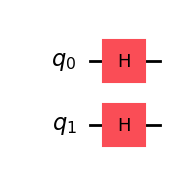

In [80]:
grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.draw('mpl')

Apply the Oracle for $|w\rangle = |11\rangle$. This oracle is specific to 2 qubits:

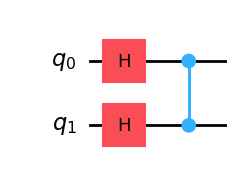

In [81]:
grover_circuit.cz(0,1) # Oracle
grover_circuit.draw('mpl')

<span id="general_diffuser"></span>
We now want to apply the diffuser ($U_s$). As with the circuit that initialises $|s\rangle$, we'll create a general diffuser (for any number of qubits) so we can use it later in other problems. 

In [ ]:
# Diffusion operator (U_s)
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.draw('mpl')

┌───┐   ┌───┐┌───┐   ┌───┐
q_0: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     ├───┤ │ ├───┤├───┤ │ ├───┤
q_1: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     └───┘   └───┘└───┘   └───┘

This is our finished circuit.

### 2.1.1 Experiment with Simulators <a id='2qubits-simulation'></a>

Let's run the circuit in simulation. First, we can verify that we have the correct statevector:

In [55]:
sv_sim = Aer.get_backend('statevector_simulator')
result = sv_sim.run(grover_circuit).result()
statevec = result.get_statevector()
from qiskit.visualization import array_to_latex
array_to_latex(statevec, prefix="|\\psi\\rangle =")

<IPython.core.display.Latex object>

As expected, the amplitude of every state that is not $|11\rangle$ is 0, this means we have a 100% chance of measuring $|11\rangle$:

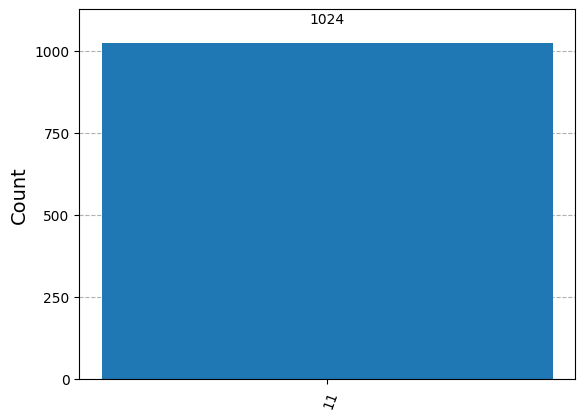

In [56]:
grover_circuit.measure_all()

qasm_sim = Aer.get_backend('qasm_simulator')
result = qasm_sim.run(grover_circuit).result()
counts = result.get_counts()
plot_histogram(counts)

### 2.1.2 Experiment with Real Devices <a id='2qubits-device'></a>

We can run the circuit on a real device as below.

In [57]:
#from qiskit_aer import Aer

#available_backends = service.backends()

#if available_backends:
#    backend_name = available_backends[0].name
#    backend = service.backend(backend_name)
#    print(f"✅ Using backend: {backend.name}")
#else:
#    print("⚠️ No IBM Quantum backend available. Using simulator.")
#    backend = Aer.get_backend("aer_simulator")


In [58]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Load IBM Quantum account
service = QiskitRuntimeService(channel="ibm_quantum", token="2555fb71a406ea27a5d2141e2e437a01c216ae9b4650343b61fd14b1c02748b7dce5e4eed99e0238acc2f1da91c26c3bc7d587ca9e9cbd154d464baefbd3b313")

# List all available backends
available_backends = service.backends()
print("Available backends:", [backend.name for backend in available_backends])

Available backends: ['ibm_brisbane', 'ibm_kyiv', 'ibm_sherbrooke']


Original Quantum Circuit:
        ┌───┐   ┌───┐┌───┐   ┌───┐ ░ ┌─┐   
   q_0: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├─░─┤M├───
        ├───┤ │ ├───┤├───┤ │ ├───┤ ░ └╥┘┌─┐
   q_1: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├─░──╫─┤M├
        └───┘   └───┘└───┘   └───┘ ░  ║ └╥┘
   c: 2/══════════════════════════════╬══╬═
                                      ║  ║ 
meas: 2/══════════════════════════════╩══╩═
                                      0  1 
✅ Using backend: ibm_brisbane (Max Qubits: 127)

Transpiled Quantum Circuit:
global phase: 5π/4
                    ┌────────┐ ┌────┐          ┌──────┐   ┌────┐   ┌──────────┐»
          q_0 -> 0 ─┤ Rz(-π) ├─┤ √X ├──────────┤1     ├───┤ √X ├───┤ Rz(-π/2) ├»
                   ┌┴────────┴┐├────┤┌────────┐│  Ecr │┌──┴────┴──┐└──┬────┬──┘»
          q_1 -> 1 ┤ Rz(-π/2) ├┤ √X ├┤ Rz(-π) ├┤0     ├┤ Rz(-π/2) ├───┤ √X ├───»
                   └──────────┘└────┘└────────┘└──────┘└──────────┘   └────┘   »
    ancilla_0 -> 2 ──────────────────────────────────────────────────────────

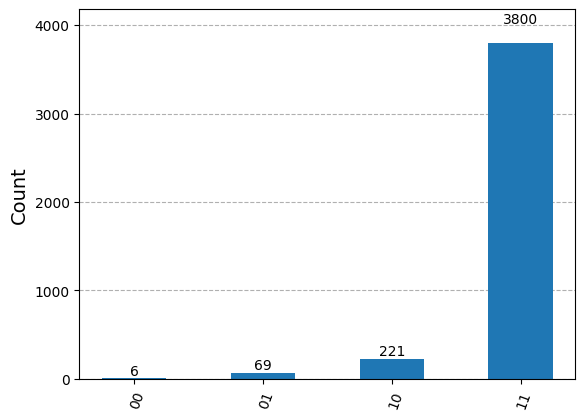

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Importing Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer  # Aer for local simulation

# Step 1: Define the Grover's Algorithm Circuit
n = 2
grover_circuit = QuantumCircuit(n, n)  # ✅ Add classical bits

# Apply Hadamard to all qubits
grover_circuit.h([0, 1])

# Apply Oracle (CZ Gate)
grover_circuit.cz(0, 1)

# Apply Diffusion Operator
grover_circuit.h([0, 1])
grover_circuit.z([0, 1])
grover_circuit.cz(0, 1)
grover_circuit.h([0, 1])

# ✅ Add Measurement
grover_circuit.measure_all()

# Print the circuit
print("Original Quantum Circuit:")
print(grover_circuit.draw())

# Step 2: Load IBM Quantum Service
service = QiskitRuntimeService(channel="ibm_quantum", token="2555fb71a406ea27a5d2141e2e437a01c216ae9b4650343b61fd14b1c02748b7dce5e4eed99e0238acc2f1da91c26c3bc7d587ca9e9cbd154d464baefbd3b313")

# Step 3: Check available backends
available_backends = service.backends()

if available_backends:
    backend_name = available_backends[0].name
    backend = service.backend(backend_name)
    print(f"✅ Using backend: {backend.name} (Max Qubits: {backend.configuration().n_qubits})")
else:
    print("⚠️ No available IBM Quantum backends. Using simulator.")
    backend = Aer.get_backend("aer_simulator")  # Use simulator

# Step 4: Transpile the circuit for the selected backend
transpiled_qc = transpile(grover_circuit, backend, optimization_level=1)
print("\nTranspiled Quantum Circuit:")
print(transpiled_qc.draw())

# Step 5: ✅ Use Sampler with a specified backend
sampler = Sampler(backend)  # ✅ Fix: Specify the backend
job = sampler.run([transpiled_qc])

# Wait for job completion and get results
result = job.result()

counts = result._pub_results[0].data.meas.get_counts()
print(counts)
# Step 6: Visualize and print results
plot_histogram(counts)


We confirm that in the majority of the cases the state $|11\rangle$ is measured. The other results are due to errors in the quantum computation. 

## 3. Example: 3 Qubits <a id='3qubits'></a>

We now go through the example of Grover's algorithm for 3 qubits with two marked states $\lvert101\rangle$ and $\lvert110\rangle$, following the implementation found in Reference [2]. The quantum circuit to solve the problem using a phase oracle is:

![image12](images/grover_circuit_3qubits.png)

1. Apply Hadamard gates to $3$ qubits initialised to $\lvert000\rangle$ to create a uniform superposition:
   $$\lvert \psi_1 \rangle = \frac{1}{\sqrt{8}} \left( 
    \lvert000\rangle + \lvert001\rangle + \lvert010\rangle + \lvert011\rangle + 
    \lvert100\rangle + \lvert101\rangle + \lvert110\rangle + \lvert111\rangle \right)
   $$

2. Mark states $\lvert101\rangle$ and $\lvert110\rangle$ using a phase oracle:
   $$\lvert \psi_2 \rangle = \frac{1}{\sqrt{8}} \left( 
    \lvert000\rangle + \lvert001\rangle + \lvert010\rangle + \lvert011\rangle + 
    \lvert100\rangle - \lvert101\rangle - \lvert110\rangle + \lvert111\rangle \right)
   $$

3. Perform the reflection around the average amplitude:
   1. Apply Hadamard gates to the qubits
      $$
      \lvert \psi_{3a} \rangle = \frac{1}{2} \left( 
      \lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right)
      $$
   
   2. Apply X gates to the qubits
      $$
      \lvert \psi_{3b} \rangle = \frac{1}{2} \left( 
      -\lvert000\rangle +\lvert011\rangle +\lvert100\rangle +\lvert111\rangle \right)
      $$
   
   3. Apply a doubly controlled Z gate between the 1, 2 (controls) and 3 (target) qubits
      $$
      \lvert \psi_{3c} \rangle = \frac{1}{2} \left( 
      -\lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right)
      $$
   
   4. Apply X gates to the qubits
      $$
      \lvert \psi_{3d} \rangle = \frac{1}{2} \left( 
      -\lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right)
      $$
   
   5. Apply Hadamard gates to the qubits
      $$
      \lvert \psi_{3e} \rangle = \frac{1}{\sqrt{2}} \left( 
      -\lvert101\rangle -\lvert110\rangle \right)
      $$

4. Measure the $3$ qubits to retrieve states $\lvert101\rangle$ and $\lvert110\rangle$

Note that since there are 2 solutions and 8 possibilities, we will only need to run one iteration (steps 2 & 3).

### 3.1 Qiskit Implementation <a id='3qubit-implementation'></a>

We now implement Grover's algorithm for the above [example](#3qubits) for $3$-qubits and searching for two marked states $\lvert101\rangle$ and $\lvert110\rangle$. **Note:** Remember that Qiskit orders it's qubits the opposite way round to this resource, so the circuit drawn will appear flipped about the horizontal.

We create a phase oracle that will mark states $\lvert101\rangle$ and $\lvert110\rangle$ as the results (step 1).

In [60]:
qc = QuantumCircuit(3)
qc.cz(0, 2)
qc.cz(1, 2)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"

<>:5: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\o'
C:\Users\Zehua Wang\AppData\Local\Temp\ipykernel_32956\3153141584.py:5: SyntaxWarning: invalid escape sequence '\o'
  oracle_ex3.name = "U$_\omega$"


In the last section, we used a diffuser specific to 2 qubits, in the cell below we will create a general diffuser for any number of qubits.


<!-- ::: q-block.reminder -->

### Detail

<details>
<summary>Creating a General Diffuser</summary>
    
Remember that we can create $U_s$ from $U_0$:

$$ U_s = H^{\otimes n} U_0 H^{\otimes n} $$

And a multi-controlled-Z gate ($MCZ$) inverts the phase of the state $|11\dots 1\rangle$:

$$
MCZ = 
\begin{bmatrix}
 1 & 0 & 0 & \cdots & 0 \\
 0 & 1 & 0 & \cdots & 0 \\
 \vdots & \vdots & \vdots & \ddots & \vdots \\
 0 & 0 & 0 & \cdots & -1 \\
\end{bmatrix}
\begin{aligned}
\\
\\
\\
\leftarrow \text{Add negative phase to} \; |11\dots 1\rangle\\
\end{aligned}
$$

Applying an X-gate to each qubit performs the transformation:

$$
\begin{aligned}
|00\dots 0\rangle & \rightarrow |11\dots 1\rangle\\
|11\dots 1\rangle & \rightarrow |00\dots 0\rangle
\end{aligned}
$$

So:

$$ U_0 = - X^{\otimes n} (MCZ) X^{\otimes n} $$

Using these properties together, we can create $U_s$ using H-gates, X-gates, and a single multi-controlled-Z gate:

$$ U_s = - H^{\otimes n} U_0 H^{\otimes n} = H^{\otimes n} X^{\otimes n} (MCZ) X^{\otimes n} H^{\otimes n} $$
    
Note that we can ignore the global phase of -1.

</details>

<!-- ::: -->

In [64]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mcx(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

We'll now put the pieces together, with the creation of a uniform superposition at the start of the circuit and a measurement at the end. Note that since there are 2 solutions and 8 possibilities, we will only need to run one iteration. 

In [74]:
#!pip install --upgrade qiskit qiskit-aer qiskit-ibm-runtime

In [66]:
n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw()

┌───┐┌─────────────┐┌────────┐ ░ ┌─┐      
   q_0: ┤ H ├┤0            ├┤0       ├─░─┤M├──────
        ├───┤│             ││        │ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 U$_\omega$ ├┤1 U$_s$ ├─░──╫─┤M├───
        ├───┤│             ││        │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2            ├┤2       ├─░──╫──╫─┤M├
        └───┘└─────────────┘└────────┘ ░  ║  ║ └╥┘
meas: 3/══════════════════════════════════╩══╩══╩═
                                          0  1  2

### 3.1.1 Experiment with Simulators  <a id='3qubits-simulation'></a>

We can run the above circuit on the simulator. 

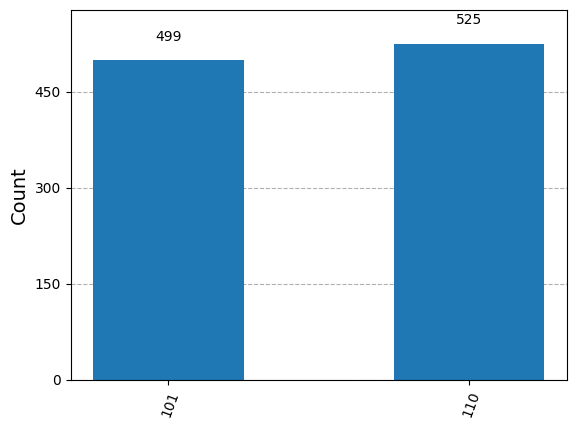

In [69]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_grover_circuit = transpile(grover_circuit, qasm_sim)
results = qasm_sim.run(transpiled_grover_circuit).result()
counts = results.get_counts()
plot_histogram(counts)

As we can see, the algorithm discovers our marked states $\lvert101\rangle$ and $\lvert110\rangle$.

### 3.1.2 Experiment with Real Devices  <a id='3qubits-device'></a>

We can run the circuit on the real device as below.

In [70]:
service = QiskitRuntimeService(channel="ibm_quantum", token="2555fb71a406ea27a5d2141e2e437a01c216ae9b4650343b61fd14b1c02748b7dce5e4eed99e0238acc2f1da91c26c3bc7d587ca9e9cbd154d464baefbd3b313")

# Step 3: Check available backends
available_backends = service.backends()

if available_backends:
    backend_name = available_backends[0].name
    backend = service.backend(backend_name)
    print(f"✅ Using backend: {backend.name} (Max Qubits: {backend.configuration().n_qubits})")
else:
    print("⚠️ No available IBM Quantum backends. Using simulator.")
    backend = Aer.get_backend("aer_simulator")  # Use simulator



✅ Using backend: ibm_brisbane (Max Qubits: 127)



Transpiled Quantum Circuit:
global phase: 5π/8
                                                                        »
    ancilla_0 -> 0 ─────────────────────────────────────────────────────»
                                                                        »
    ancilla_1 -> 1 ─────────────────────────────────────────────────────»
                                                                        »
    ancilla_2 -> 2 ─────────────────────────────────────────────────────»
                                                                        »
    ancilla_3 -> 3 ─────────────────────────────────────────────────────»
                   ┌─────────┐┌────┐          ┌──────┐┌──────────┐┌────┐»
          q_0 -> 4 ┤ Rz(π/2) ├┤ √X ├──────────┤0     ├┤ Rz(-π/2) ├┤ √X ├»
                   └┬────────┤├────┤┌────────┐│  Ecr │└┬────────┬┘├────┤»
          q_2 -> 5 ─┤ Rz(-π) ├┤ √X ├┤ Rz(-π) ├┤1     ├─┤ Rz(-π) ├─┤ √X ├»
                   ┌┴────────┤├────┤└────────┘└──────┘ └────────

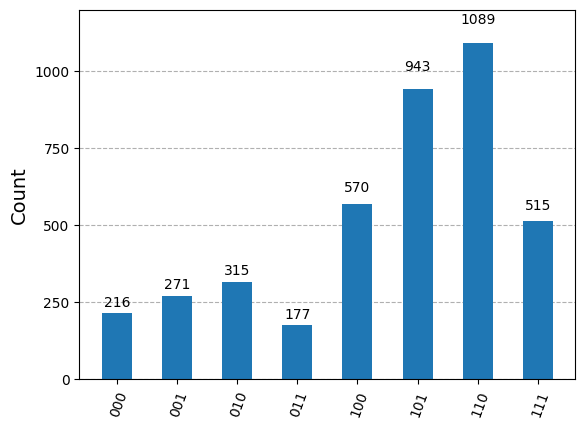

In [72]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
# Step 4: Transpile the circuit for the selected backend
transpiled_qc = transpile(grover_circuit, backend, optimization_level=1)
print("\nTranspiled Quantum Circuit:")
print(transpiled_qc.draw())
# Step 5: ✅ Use Sampler with a specified backend
sampler = Sampler(backend)  # ✅ Fix: Specify the backend
job = sampler.run([transpiled_qc])

# Wait for job completion and get results
result = job.result()

counts = result._pub_results[0].data.meas.get_counts()
print(counts)
# Step 6: Visualize and print results
plot_histogram(counts)

As we can (hopefully) see, there is a higher chance of measuring $\lvert101\rangle$ and $\lvert110\rangle$. The other results are due to errors in the quantum computation. 

## 4. Problems <a id='problems'></a>

The function `grover_problem_oracle` below takes a number of qubits (`n`), and a `variant` and returns an n-qubit oracle. The function will always return the same oracle for the same `n` and `variant`. You can see the solutions to each oracle by setting `print_solutions = True` when calling `grover_problem_oracle`.

In [73]:
from qiskit_textbook.problems import grover_problem_oracle
## Example Usage
n = 4
oracle = grover_problem_oracle(n, variant=1)  # 0th variant of oracle, with n qubits
qc = QuantumCircuit(n)
qc.append(oracle, [0,1,2,3])
qc.draw()

ModuleNotFoundError: No module named 'qiskit_textbook'

1. `grover_problem_oracle(4, variant=2)` uses 4 qubits and has 1 solution.    
   a. How many iterations do we need to have a > 90% chance of measuring this solution?    
   b. Use Grover's algorithm to find this solution state.
   c. What happens if we apply more iterations than the number we calculated in problem 1a above? Why?

2. With 2 solutions and 4 qubits, how many iterations do we need for a >90% chance of measuring a solution? Test your answer using the oracle `grover_problem_oracle(4, variant=1)` (which has two solutions).

3. Create a function, `grover_solver(oracle, iterations)` that takes as input:
    - A Grover oracle as a gate (`oracle`)
    - An integer number of iterations (`iterations`)
    
   and returns a `QuantumCircuit` that performs Grover's algorithm on the '`oracle`' gate, with '`iterations`' iterations.

## 4.1 Solving Sudoku using Grover's Algorithm <a id="sudoku"></a>

The oracles used throughout this chapter so far have been created with prior knowledge of their solutions. We will now solve a simple problem using Grover's algorithm, for which we do not necessarily know the solution beforehand. Our problem is a 2×2 binary sudoku, which in our case has two simple rules:

- No column may contain the same value twice
- No row may contain the same value twice

If we assign each square in our sudoku to a variable like so:

![2×2 binary sudoku, with each square allocated to a different variable](images/binary_sudoku.png)

we want our circuit to output a solution to this sudoku.

Note that, while this approach of using Grover's algorithm to solve this problem is not practical (you can probably find the solution in your head!), the purpose of this example is to demonstrate the conversion of classical [decision problems](https://en.wikipedia.org/wiki/Decision_problem) into oracles for Grover's algorithm.

### 4.1.1 Turning the Problem into a Circuit

We want to create an oracle that will help us solve this problem, and we will start by creating a circuit that identifies a correct solution. Similar to how we created a classical adder using quantum circuits in [_The Atoms of Computation_](/course/ch-states/the-atoms-of-computation), we simply need to create a _classical_ function on a quantum circuit that checks whether the state of our variable bits is a valid solution.

Since we need to check down both columns and across both rows, there are 4 conditions we need to check:

```
v0 ≠ v1   # check along top row
v2 ≠ v3   # check along bottom row
v0 ≠ v2   # check down left column
v1 ≠ v3   # check down right column
```

Remember we are comparing classical (computational basis) states. For convenience, we can compile this set of comparisons into a list of clauses:

In [ ]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

We will assign the value of each variable to a bit in our circuit. To check these clauses computationally, we will use the `XOR` gate (we came across this in the atoms of computation).

In [ ]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

Convince yourself that the `output0` bit in the circuit below will only be flipped if `input0 ≠ input1`:

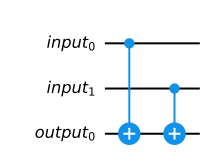

In [ ]:
# We will use separate registers to name the bits
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
qc = QuantumCircuit(in_qubits, out_qubit)
XOR(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw()

This circuit checks whether `input0 == input1` and stores the output to `output0`. To check each clause, we repeat this circuit for each pairing in `clause_list` and store the output to a new bit:

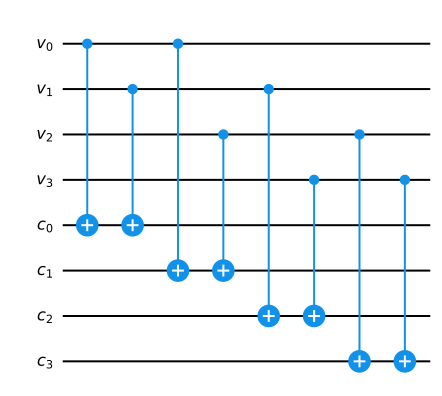

In [ ]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')  # variable bits
clause_qubits = QuantumRegister(4, name='c')  # bits to store clause-checks

# Create quantum circuit
qc = QuantumCircuit(var_qubits, clause_qubits)

# Use XOR gate to check each clause
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

qc.draw()

The final state of the bits `c0, c1, c2, c3` will only all be `1` in the case that the assignments of `v0, v1, v2, v3` are a solution to the sudoku. To complete our checking circuit, we want a single bit to be `1` if (and only if) all the clauses are satisfied, this way we can look at just one bit to see if our assignment is a solution. We can do this using a multi-controlled-Toffoli-gate:

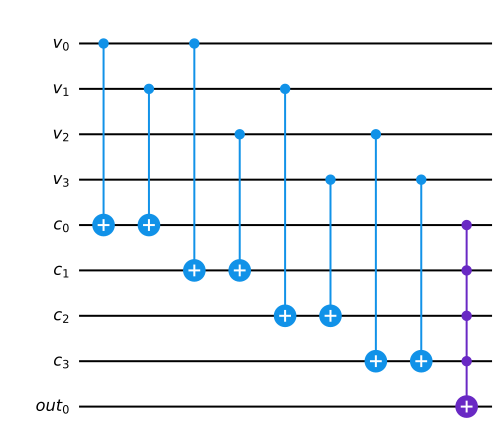

In [ ]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

# Compute clauses
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

# Flip 'output' bit if all clauses are satisfied
qc.mct(clause_qubits, output_qubit)

qc.draw()

The circuit above takes as input an initial assignment of the bits `v0`, `v1`, `v2` and `v3`, and all other bits should be initialised to `0`. After running the circuit, the state of the `out0` bit tells us if this assignment is a solution or not; `out0 = 0` means the assignment _is not_ a solution, and `out0 = 1` means the assignment _is_ a solution.

**Important:** Before you continue, it is important you fully understand this circuit and are convinced it works as stated in the paragraph above.

### 4.1.2 Uncomputing, and Completing the Oracle

We can now turn this checking circuit into a Grover oracle using [phase kickback](/course/ch-gates/phase-kickback). To recap, we have 3 registers: 
- One register which stores our sudoku variables (we'll say $x = v_3, v_2, v_1, v_0$)
- One register that stores our clauses (this starts in the state $|0000\rangle$ which we'll abbreviate to $|0\rangle$)
- And one qubit ($|\text{out}_0\rangle$) that we've been using to store the output of our checking circuit. 

To create an oracle, we need our circuit ($U_\omega$) to perform the transformation:

$$
U_\omega|x\rangle|0\rangle|\text{out}_0\rangle = |x\rangle|0\rangle|\text{out}_0\oplus f(x)\rangle
$$

If we set the `out0` qubit to the superposition state $|{-}\rangle$ we have:

$$
\begin{aligned}
U_\omega|x\rangle|0\rangle|{-}\rangle 
&= U_\omega|x\rangle|0\rangle\otimes\tfrac{1}{\sqrt{2}}(|0\rangle - |1\rangle)\\
&= |x\rangle|0\rangle\otimes\tfrac{1}{\sqrt{2}}(|0\oplus f(x)\rangle - |1\oplus f(x)\rangle)
\end{aligned}
$$

If $f(x) = 0$, then we have the state:

$$
\begin{aligned}
&= |x\rangle|0\rangle\otimes \tfrac{1}{\sqrt{2}}(|0\rangle - |1\rangle)\\
&= |x\rangle|0\rangle|-\rangle\\
\end{aligned}
$$


(i.e. no change). But if $f(x) = 1$ (i.e. $x = \omega$), we introduce a negative phase to the $|{-}\rangle$ qubit:

$$
\begin{aligned}
&= \phantom{-}|x\rangle|0\rangle\otimes\tfrac{1}{\sqrt{2}}(|1\rangle - |0\rangle)\\
&= \phantom{-}|x\rangle|0\rangle\otimes -\tfrac{1}{\sqrt{2}}(|0\rangle - |1\rangle)\\
&= -|x\rangle|0\rangle|-\rangle\\
\end{aligned}
$$

This is a functioning oracle that uses two auxiliary registers in the state $|0\rangle|{-}\rangle$:

$$
U_\omega|x\rangle|0\rangle|{-}\rangle = \Bigg\{
\begin{aligned}
\phantom{-}|x\rangle|0\rangle|-\rangle \quad \text{for} \; x \neq \omega \\
-|x\rangle|0\rangle|-\rangle \quad \text{for} \; x = \omega \\
\end{aligned}
$$

To adapt our checking circuit into a Grover oracle, we need to guarantee the bits in the second register (`c`) are always returned to the state $|0000\rangle$ after the computation. To do this, we simply repeat the part of the circuit that computes the clauses which guarantees `c0 = c1 = c2 = c3 = 0` after our circuit has run. We call this step _'uncomputation'_.

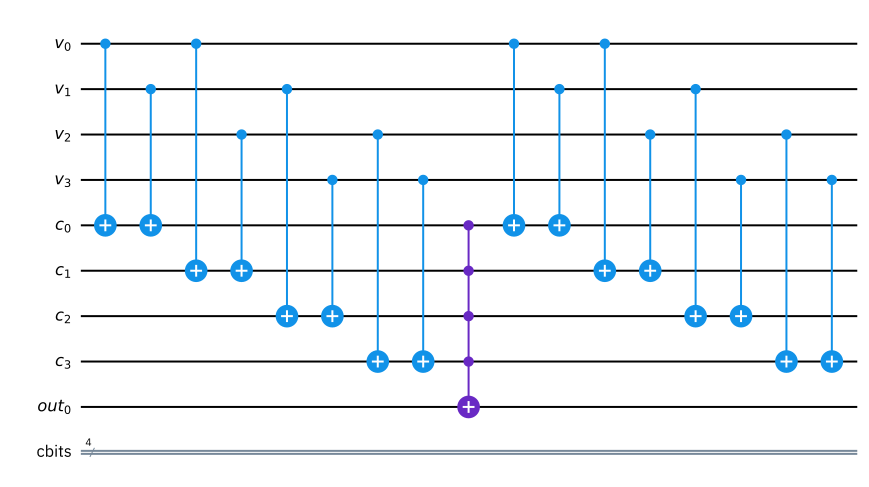

In [ ]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def sudoku_oracle(qc, clause_list, clause_qubits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

sudoku_oracle(qc, clause_list, clause_qubits)
qc.draw()

In summary, the circuit above performs:

$$
U_\omega|x\rangle|0\rangle|\text{out}_0\rangle = \Bigg\{
\begin{aligned}
|x\rangle|0\rangle|\text{out}_0\rangle \quad \text{for} \; x \neq \omega \\
|x\rangle|0\rangle\otimes X|\text{out}_0\rangle \quad \text{for} \; x = \omega \\
\end{aligned}
$$

and if the initial state of $|\text{out}_0\rangle = |{-}\rangle$,:

$$
U_\omega|x\rangle|0\rangle|{-}\rangle = \Bigg\{
\begin{aligned}
\phantom{-}|x\rangle|0\rangle|-\rangle \quad \text{for} \; x \neq \omega \\
-|x\rangle|0\rangle|-\rangle \quad \text{for} \; x = \omega \\
\end{aligned}
$$

### 4.1.3 The Full Algorithm

All that's left to do now is to put all these components together.

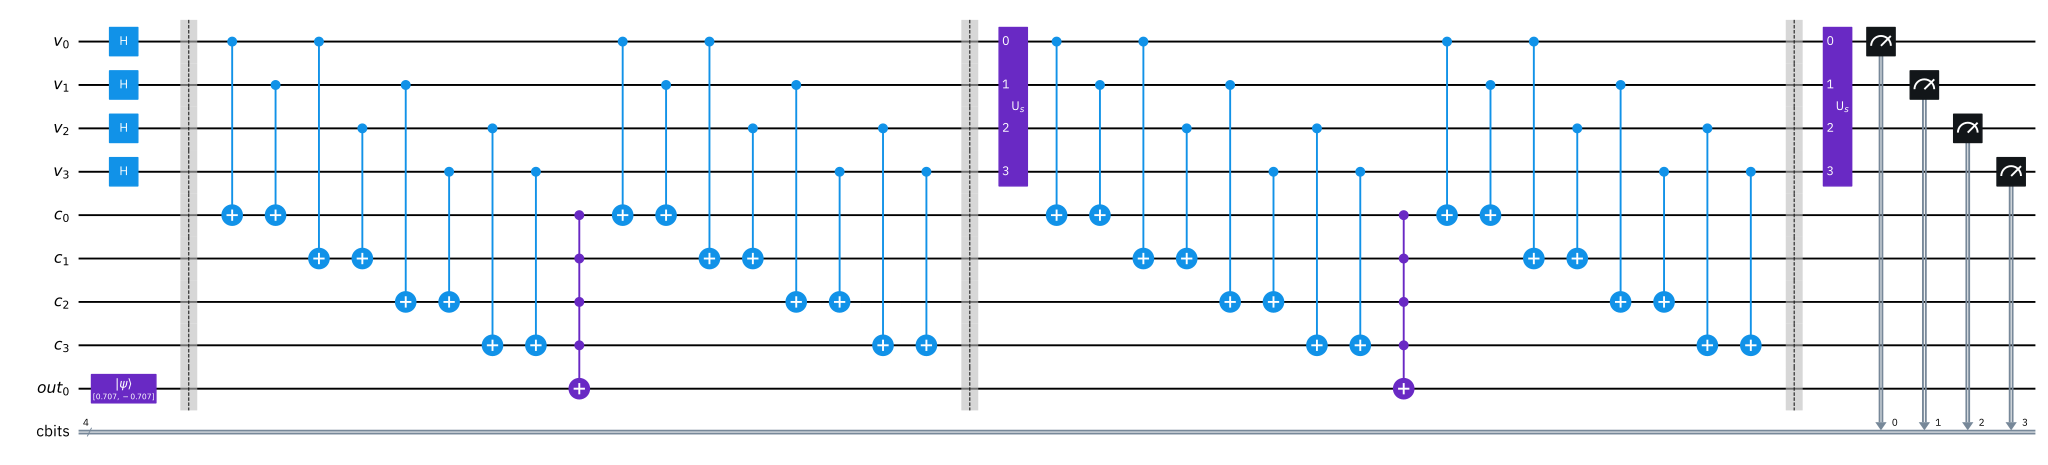

In [ ]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

## First Iteration
# Apply our oracle
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

## Second Iteration
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw(fold=-1)

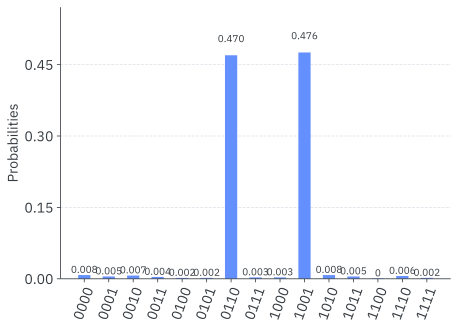

In [ ]:
# Simulate and plot results
qasm_simulator = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_simulator)
result = qasm_sim.run(transpiled_qc).result()
plot_histogram(result.get_counts())

There are two bit strings with a much higher probability of measurement than any of the others, `0110` and `1001`. These correspond to the assignments:
```
v0 = 0
v1 = 1
v2 = 1
v3 = 0
```
and
```
v0 = 1
v1 = 0
v2 = 0
v3 = 1
```
which are the two solutions to our sudoku! The aim of this section is to show how we can create Grover oracles from real problems. While this specific problem is trivial, the process can be applied (allowing large enough circuits) to any decision problem. To recap, the steps are:



&nbsp;

<!-- ::: q-block.exercise -->

### Your turn

1. Create a reversible classical circuit that identifies a correct solution
2. Use phase kickback and uncomputation to turn this circuit into an oracle
3. Use Grover's algorithm to solve this oracle

<!-- ::: -->


## 4.2 The Triangle-finding Problem Using Grover <a id='tri'></a>


One of the famous [graph theory](gloss:gt) problems is the [triangle-finding problem](https://en.wikipedia.org/wiki/Triangle-free_graph). In the triangle-finding problem, we are given a graph that may or may not contain a triangle. Our task is to find the triangle/s within the graph and point out the nodes that form the triangle. For example, the graph below is a 4-node graph with a triangle between nodes `0`,`1`, and `2`.     


![image12](images/grover_tri.png)


We can apply Grover's algorithm to this problem, we are going to give the algorithm a list of _edges_ and the number of nodes in the graph. The algorithm, then, will do the rest. It will try to check if there's a triangle in the graph or not, and if so it will mark the nodes forming that triangle.   


Now, let's go through Grover's algorithm steps and see how can we construct each step to solve the triangle finding problem. But first, let's define our input, which is the list of edges.

In [ ]:
#Edges list
edges =[(0, 1), (0, 2), (1, 2), (2, 3)]
#Number of nodes
n_nodes = 4

### 4.2.1 The state preparation

To solve the problem, let's first focus on the example above, which is the case of finding a triangle in a 4-node graph. to do that, we need to go over all subgraphs within our graph and check if any of them a triangle. To do that we will need 4-qubits, each qubit represents a node in the graph. The state of the qubit will indicate whether the node in any subgraph or not. For example, in the graph above, the triangle is between nodes 0,1, and 2, we can rephrase that using the state `1110`. The nodes with state 1 are in the subgraph (triangle) and the node with state 0 is not.   

For the state preparation, we will need to create a superposition of all possible states `0000`, to `1111`, which can be done simply using `4` Hadamard gates. Doing so, will we need to rotate over the oracle and diffusion `3` times.  
But, if each `1` in the state represent an active node, we don't really need to look through the entire Hilbert space, we only need to look through the subgraphs with three nodes.    

This is a good example of using another type of symmetric states to prepare the search space. Here since we only need to consider states with three 1's, we can think of another way to form our search space. One way to create a superposition over only states with three active nodes is through using the W-state followed by `4 NOT gates`. This will decrease the number of rotations needed from `3` to `1`.

So, we first need to implement the W-state. W-states have the form:

$$

|W\rangle = {\frac{1}{{\sqrt{n}}}}(|100...0\rangle + ... + |01...0\rangle + |00...01\rangle)

$$

In our case, we need to construct $|W_{3}\rangle$ states as described in reference 6.

In [ ]:
#We used the W state implementation from W state in reference 6
def control_rotation (qcir,cQbit,tQbit,theta):
    """ Create an intermediate controlled rotation using only unitary gate and controlled-NOT
    
    Args:
    qcir: QuantumCircuit instance to apply the controlled rotation to.
    cQbit: control qubit. 
    tQbit: target qubit.
    theta: rotation angle.
    
    Returns:
    A modified version of the QuantumCircuit instance with control rotation applied.
    
    """
    theta_dash = math.asin(math.cos(math.radians(theta/2)))
    qcir.u(theta_dash,0,0,tQbit)
    qcir.cx(cQbit,tQbit)
    qcir.u(-theta_dash,0,0,tQbit)
    return qcir


def wn (qcir,qbits): 
    """ Create the W-state using the control-rotation function.
    
    Args:
    qcir: QuantumCircuit instance used to construct the W-state.
    qbits: the qubits used to construct the W-state.
    
    Returns:
    A modified version of the QuantumCircuit instance with the W-state construction gates.
    
    """
    for i in range(len(qbits)):
        if i == 0:
            qcir.x(qbits[0])
            qcir.barrier()
        else:
            p = 1/(len(qbits)-(i-1))
            theta = math.degrees(math.acos(math.sqrt(p)))
            theta = 2* theta
            qcir = control_rotation(qcir,qbits[i-1],qbits[i],theta)
            qcir.cx(qbits[i],qbits[i-1])
            qcir.barrier()
    return qcir,qbits

sub_qbits = QuantumRegister(n_nodes)
sub_cir = QuantumCircuit(sub_qbits, name="state_prep")
sub_cir, sub_qbits = wn(sub_cir, sub_qbits)
sub_cir.x(sub_qbits)
stat_prep = sub_cir.to_instruction()
inv_stat_prep = sub_cir.inverse().to_instruction()

### 4.2.2 The oracle

The oracle is what's gonna mark the correct answer. In these cases, the oracle needs to take every subgraph and count the number of edges in that subgraph. If the number of edges is `3`, then we have a triangle, if not, it will proceed to the next subgraph.    

![image13](images/grover_tri_oracle.png)

For every edge in the graph, we will need one or two `CNOT` gates. These `CNOT` gates will apply to two ancillary qubits, that should be in state `11` if a triangle is found. The number of ancillary qubits here is two because a triangle has `3 edges` that is $11_{b}$. Then the final step in the oracle is to apply one more `Toffoli`, that will only be active if a triangle is found by changing the state of another qubit, let's call it, `tri_flag`, to `1`.

&nbsp;

<!-- ::: q-block.reminder -->

### Reminder

<details>
    <summary>Oracle</summary>
    The oracle's job is to verify and mark the correct answer. So, when you construct an oracle, you're basically building a circuit to verify certain conditions.
</details>

<!-- ::: -->

In [ ]:
def edge_counter(qc,qubits,anc,flag_qubit,k):
    bin_k = bin(k)[2:][::-1]
    l = []
    for i in range(len(bin_k)):
        if int(bin_k[i]) == 1:
            l.append(qubits[i])
    qc.mct(l,flag_qubit,[anc])
    
    
def oracle(n_nodes, edges, qc, nodes_qubits, edge_anc, ancilla, neg_base):
    k = 3 #k is the number of edges, in case of a triangle, it's 3
    #1- edge counter
    #forward circuit
    qc.barrier()
    qc.ccx(nodes_qubits[edges[0][0]],nodes_qubits[edges[0][1]],edge_anc[0])
    for i in range(1,len(edges)):
        qc.mct([nodes_qubits[edges[i][0]],nodes_qubits[edges[i][1]],edge_anc[0]], edge_anc[1], [ancilla[0]])
        qc.ccx(nodes_qubits[edges[i][0]],nodes_qubits[edges[i][1]],edge_anc[0])
    #----------------------------------------------------------------------------------------------------------
     #Edges check Qubit
    edg_k = int((k/2)*(k-1))
    edge_counter(qc,edge_anc,ancilla[0],neg_base[0],edg_k)
    #----------------------------------------------------------------------------------------------------------

    #4- Reverse edge count
    for i in range(len(edges)-1,0,-1):
        qc.ccx(nodes_qubits[edges[i][0]],nodes_qubits[edges[i][1]],edge_anc[0])
        qc.mct([nodes_qubits[edges[i][0]],nodes_qubits[edges[i][1]],edge_anc[0]], edge_anc[1], [ancilla[0]])
    qc.ccx(nodes_qubits[edges[0][0]],nodes_qubits[edges[0][1]],edge_anc[0])
    qc.barrier()

### 4.2.3 The diffusion operator

As we said before, the diffusion operator construction depends on the type of state preparation we used, in this case, the W-state. So, we need the inverses W-state, a multi-controlled Z gate and the original W-state to form the diffusion operator.

In [ ]:
def cnz(qc, num_control, node, anc):
    """Construct a multi-controlled Z gate
    
    Args:
    num_control :  number of control qubits of cnz gate
    node :             node qubits
    anc :               ancillaly qubits
    """
    if num_control>2:
        qc.ccx(node[0], node[1], anc[0])
        for i in range(num_control-2):
            qc.ccx(node[i+2], anc[i], anc[i+1])
        qc.cz(anc[num_control-2], node[num_control])
        for i in range(num_control-2)[::-1]:
            qc.ccx(node[i+2], anc[i], anc[i+1])
        qc.ccx(node[0], node[1], anc[0])
    if num_control==2:
        qc.h(node[2])
        qc.ccx(node[0], node[1], node[2])
        qc.h(node[2])
    if num_control==1:
        qc.cz(node[0], node[1])

In [ ]:
def grover_diff(qc, nodes_qubits,edge_anc,ancilla,stat_prep,inv_stat_prep):
    qc.append(inv_stat_prep,qargs=nodes_qubits)
    qc.x(nodes_qubits)
    #====================================================
        #3 control qubits Z gate
    cnz(qc,len(nodes_qubits)-1,nodes_qubits[::-1],ancilla)
    #====================================================
    qc.x(nodes_qubits)
    qc.append(stat_prep,qargs=nodes_qubits) 

### 4.2.4 Putting it all together

Now that we have all the components of the algorithm built and running, we can put them together.

In [ ]:
# Grover algo function
def grover(n_nodes,stat_prep,inv_stat_prep):
    #N = 2**n_nodes  # for optimal iterations count if the state prep is done using only H gates.
    N = math.comb(n_nodes, 3) #Since we are using W-state to perform initial preparation.
    nodes_qubits = QuantumRegister(n_nodes, name='nodes')
    edge_anc = QuantumRegister(2, name='edge_anc')
    ancilla = QuantumRegister(n_nodes-2, name = 'cccx_diff_anc')
    neg_base = QuantumRegister(1, name='check_qubits')
    class_bits = ClassicalRegister(n_nodes, name='class_reg')
    tri_flag = ClassicalRegister(3, name='tri_flag')
    qc = QuantumCircuit(nodes_qubits, edge_anc, ancilla, neg_base, class_bits, tri_flag)
    # Initialize qunatum flag qubits in |-> state
    qc.x(neg_base[0])
    qc.h(neg_base[0])
    # Initializing i/p qubits in superposition
    qc.append(stat_prep,qargs=nodes_qubits)
    qc.barrier()
    # Calculate iteration count
    iterations = math.floor(math.pi/4*math.sqrt(N))
    # Calculate iteration count
    for i in np.arange(iterations):
        qc.barrier()
        oracle(n_nodes, edges, qc, nodes_qubits, edge_anc,  ancilla, neg_base)
        qc.barrier()
        grover_diff(qc, nodes_qubits,edge_anc,ancilla,stat_prep,inv_stat_prep)
    qc.measure(nodes_qubits,class_bits)
    return qc

Now, let's run the code and plot the histogram to see if our algorithm works as expected.

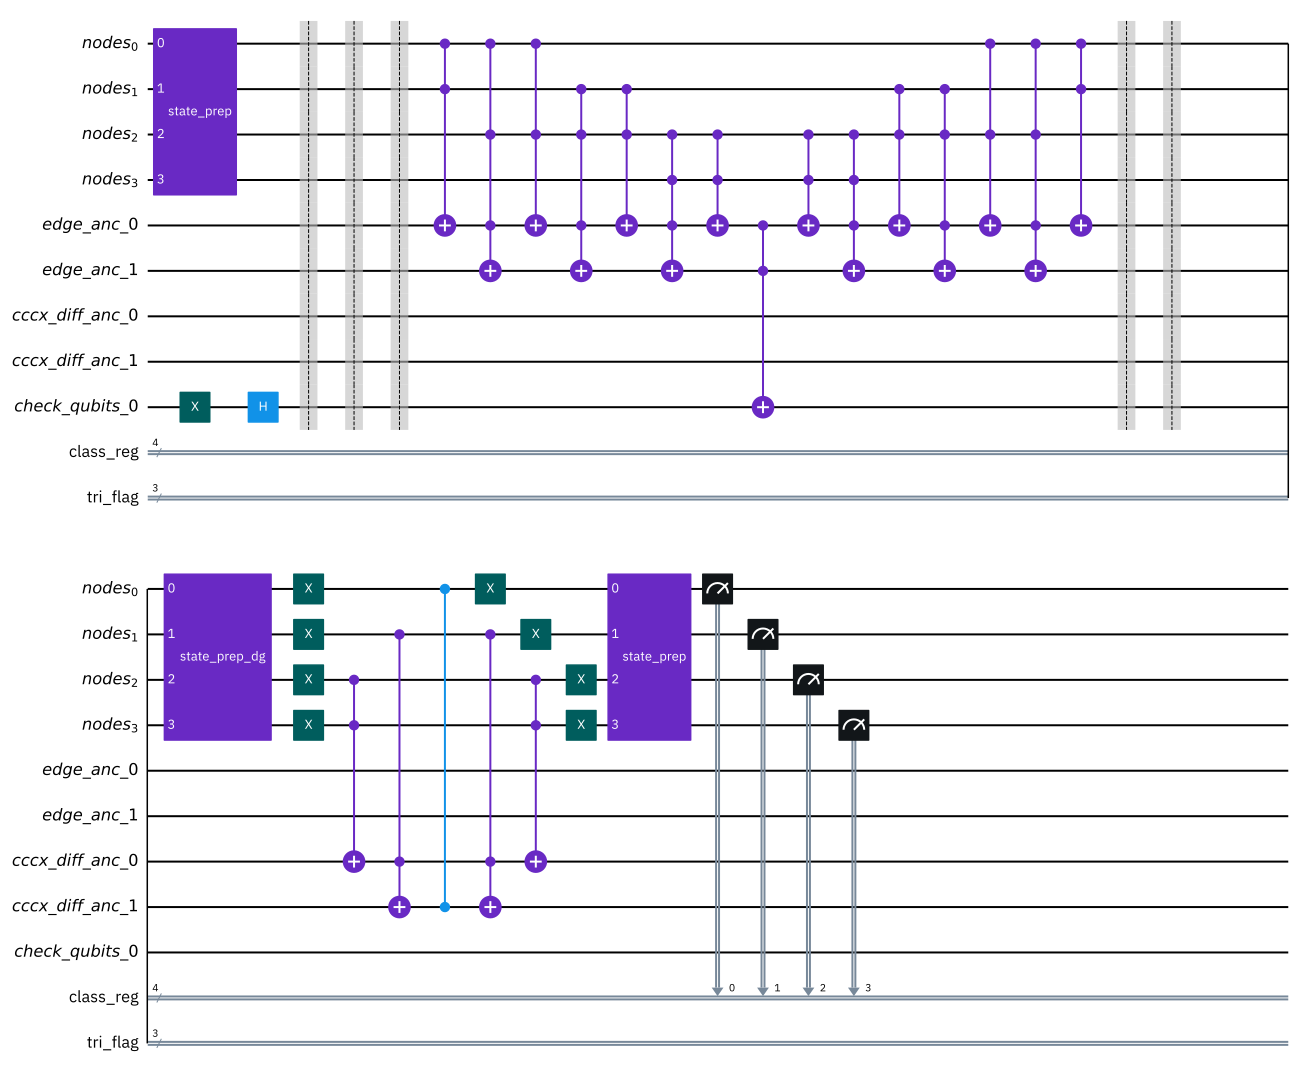

In [ ]:
qc = grover(n_nodes,stat_prep,inv_stat_prep)
qc.draw()

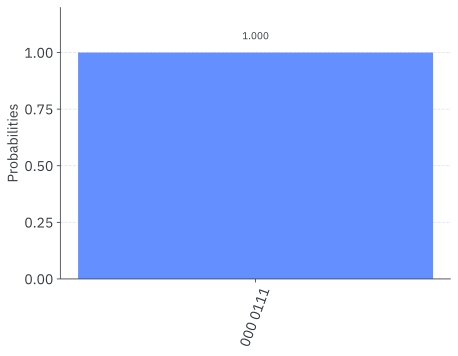

In [ ]:
# Simulate and plot results
qasm_simulator = Aer.get_backend('qasm_simulator')
#transpiled_qc = transpile(qc, qasm_simulator)
# Execute circuit and show results
ex = execute(qc, qasm_simulator, shots = 5000)
res = ex.result().get_counts(qc)
plot_histogram(res)

<!-- ::: q-block.exercise -->

### Your turn

Can you extend this problem to find a triangle in any size graph?

Try in [IBM Quantum Lab](https://quantum-computing.ibm.com/lab)

<!-- ::: -->


## 5. References <a id='references'></a>

1. L. K. Grover (1996), "A fast quantum mechanical algorithm for database search", Proceedings of the 28th Annual ACM Symposium on the Theory of Computing (STOC 1996), [doi:10.1145/237814.237866](http://doi.acm.org/10.1145/237814.237866), [arXiv:quant-ph/9605043](https://arxiv.org/abs/quant-ph/9605043)
2. C. Figgatt, D. Maslov, K. A. Landsman, N. M. Linke, S. Debnath & C. Monroe (2017), "Complete 3-Qubit Grover search on a programmable quantum computer", Nature Communications, Vol 8, Art 1918, [doi:10.1038/s41467-017-01904-7](https://doi.org/10.1038/s41467-017-01904-7), [arXiv:1703.10535 ](https://arxiv.org/abs/1703.10535)
3. I. Chuang & M. Nielsen, "Quantum Computation and Quantum Information", Cambridge: Cambridge University Press, 2000.   
4. Marconi, C., Aloy, A., Tura, J., & Sanpera, A. (2021). Entangled symmetric states and copositive matrices. Quantum, 5, 561.
5. R. Prevedel, G. Cronenberg, M. S. Tame, M. Paternostro, P. Walther, M. S. Kim, and A. Zeilinger, “Experimental realization of dicke states of up to six qubits for multiparty quantum networking,” Physical Review Letters, vol. 103, no. 2, Jul 2009.   
6. D. Cruz, R. Fournier, F. Gremion, A. Jeannerot, K. Komagata, T. Tosic, J. Thiesbrummel, C. L. Chan, N. Macris, M.-A. Dupertuis et al., “Efficient quantum algorithms for ghz and w states, and implementation on the ibm quantum computer,” Advanced Quantum Technologies, vol. 2, no. 5-6, p.1900015, 2019. https://doi.org/10.1002/qute.201900015
7. Magniez, F., Santha, M., & Szegedy, M. (2007). Quantum algorithms for the triangle problem. SIAM Journal on Computing, 37(2), 413-424.

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table

/usr/local/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
